<a href="https://colab.research.google.com/github/CatrielMiranda/EntregaFinalCH/blob/main/EntregaFinalMirandaCatriel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Entrenamiento y Optimización de Modelos de Machine Learning
**Dataset:** `tmdb_5000_movies.csv`  
**Autor:** Edgardo Catriel Miranda  
**Fecha:** 13/11/2025

## Abstracto / Motivación
En este trabajo analizamos datos del conjunto TMDB 5000 Movies para abordar dos problemas que interesan a la industria cinematográfica:
1. **Regresión:** predecir la recaudación (`revenue`) de una película (usaremos `log1p(revenue)` para el modelado).  
2. **Clasificación binaria:** predecir si una película será un **hit** (revenue > mediana).

Público objetivo: analistas de datos de productoras/cines, equipos de marketing y evaluadores académicos.  
El notebook contiene: EDA, ingeniería de atributos (incluye features textuales mediante TF-IDF), entrenamiento de modelos (RandomForest y XGBoost), optimización de hiperparámetros con RandomizedSearchCV, selección por métricas, interpretabilidad con SHAP y recomendaciones finales.


In [3]:

!pip install xgboost shap category_encoders scikit-learn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast, os, joblib
from collections import Counter

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
import shap
import category_encoders as ce

pd.set_option('display.max_columns', 200)
RND = 42
print("Librerías cargadas")


Librerías cargadas


In [4]:

df = pd.read_csv('/tmdb_5000_movies.csv')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
print("Shape:", df.shape)
display(df.head(3))
print("\nNulos por columna (top 20):")
display(df.isnull().sum().sort_values(ascending=False).head(20))


Shape: (4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466



Nulos por columna (top 20):


,0
homepage,3091
tagline,844
overview,3
runtime,2
release_date,1
id,0
budget,0
genres,0
original_title,0
popularity,0


In [5]:

df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce').fillna(0)
df['budget']  = pd.to_numeric(df['budget'], errors='coerce').fillna(0)
df['log1p_revenue'] = np.log1p(df['revenue'])
median_rev = df['revenue'].median()
df['hit'] = (df['revenue'] > median_rev).astype(int)

print("Mediana de revenue:", median_rev)
print("Distribución target clasificación (hit):")
print(df['hit'].value_counts(normalize=True))


Mediana de revenue: 19170001.0
Distribución target clasificación (hit):
hit
0    0.500104
1    0.499896
Name: proportion, dtype: float64


In [6]:

def parse_names_from_jsoncol(s):
    if pd.isnull(s): return []
    try:
        lst = ast.literal_eval(s)
        return [d.get('name') for d in lst if isinstance(d, dict) and 'name' in d]
    except Exception:
        return []

df['genres_list'] = df['genres'].apply(parse_names_from_jsoncol)
df['num_genres'] = df['genres_list'].apply(len)

df['keywords_list'] = df['keywords'].apply(parse_names_from_jsoncol)
df['num_keywords'] = df['keywords_list'].apply(len)

df['prod_companies_list'] = df['production_companies'].apply(parse_names_from_jsoncol)
df['num_prod_companies'] = df['prod_companies_list'].apply(len)

display(df[['title','genres_list','num_genres']].head())


,title,genres_list,num_genres
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",4
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",3
2,Spectre,"[Action, Adventure, Crime]",3
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",4
4,John Carter,"[Action, Adventure, Science Fiction]",3


In [7]:

df['has_homepage'] = df['homepage'].notnull().astype(int)
df['overview_len'] = df['overview'].fillna('').apply(lambda s: len(s.split()))
df['tagline_len'] = df['tagline'].fillna('').apply(lambda s: len(s.split()))
df['title_len'] = df['title'].fillna('').apply(lambda s: len(s.split()))
df['release_year'] = df['release_date'].dt.year.fillna(0).astype(int)
df['release_month'] = df['release_date'].dt.month.fillna(0).astype(int)
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce').fillna(0)
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce').fillna(0)
df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce').fillna(0)

display(df[['title','budget','revenue','log1p_revenue','overview_len']].head())


,title,budget,revenue,log1p_revenue,overview_len
0,Avatar,237000000,2787965087,21.748578,28
1,Pirates of the Caribbean: At World's End,300000000,961000000,20.683485,34
2,Spectre,245000000,880674609,20.596199,41
3,The Dark Knight Rises,250000000,1084939099,20.804790,65
4,John Carter,260000000,284139100,19.464974,55


In [8]:

all_genres = Counter([g for sub in df['genres_list'] for g in sub])
top_genres = [g for g,_ in all_genres.most_common(10)]
for g in top_genres:
    df[f'genre_{g}'] = df['genres_list'].apply(lambda lst: int(g in lst))

top_langs = df['original_language'].value_counts().index[:10].tolist()
df['orig_lang_top'] = df['original_language'].apply(lambda x: x if x in top_langs else 'other')

print("Top genres:", top_genres)
display(df[['title'] + [f'genre_{g}' for g in top_genres]].head())


Top genres: ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime', 'Science Fiction', 'Horror', 'Family']


,title,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Adventure,genre_Crime,genre_Science Fiction,genre_Horror,genre_Family
0,Avatar,0,0,0,1,0,1,0,1,0,0
1,Pirates of the Caribbean: At World's End,0,0,0,1,0,1,0,0,0,0
2,Spectre,0,0,0,1,0,1,1,0,0,0
3,The Dark Knight Rises,1,0,1,1,0,0,1,0,0,0
4,John Carter,0,0,0,1,0,1,0,1,0,0


In [9]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


corpus = df['overview'].fillna('')

tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(corpus)


svd = TruncatedSVD(n_components=50, random_state=RND)
X_svd = svd.fit_transform(X_tfidf)


for i in range(X_svd.shape[1]):
    df[f'tfidf_{i}'] = X_svd[:, i]

print("TF-IDF + SVD generó", X_svd.shape[1], "features")


TF-IDF + SVD generó 50 features


In [10]:

base_numeric = [
    'budget','popularity','runtime','vote_average','vote_count',
    'overview_len','tagline_len','title_len',
    'num_genres','num_keywords','num_prod_companies',
    'release_year','release_month','has_homepage'
]
genre_cols = [f'genre_{g}' for g in top_genres]
tfidf_cols = [f'tfidf_{i}' for i in range(50)]
cat_cols = ['orig_lang_top','status']

features = base_numeric + genre_cols + tfidf_cols + cat_cols


for c in features:
    if c not in df.columns:
        df[c] = 0

print("Número de features:", len(features))


Número de features: 76


In [11]:

from category_encoders import TargetEncoder

num_cols = base_numeric + genre_cols + tfidf_cols
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat_te', TargetEncoder(), cat_cols)
], remainder='drop')


df_sorted = df.sort_values('release_date').reset_index(drop=True)
X = df_sorted[features]
y_reg = df_sorted['log1p_revenue']
y_clf = df_sorted['hit']

cut = int(len(df_sorted)*0.8)
X_train = X.iloc[:cut]; X_test = X.iloc[cut:]
ytr_reg = y_reg.iloc[:cut]; yte_reg = y_reg.iloc[cut:]
ytr_clf = y_clf.iloc[:cut]; yte_clf = y_clf.iloc[cut:]


X_train_prep = preprocessor.fit_transform(X_train, ytr_reg)
X_test_prep  = preprocessor.transform(X_test)

print("X_train_prep shape:", X_train_prep.shape)


X_train_prep shape: (3842, 76)


In [12]:

rf = RandomForestRegressor(n_estimators=200, random_state=RND, n_jobs=-1)
rf.fit(X_train_prep, ytr_reg)
pred_rf = rf.predict(X_test_prep)

def reg_metrics(y_true, y_pred):
    return {'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred)}

print("RF (reg) metrics:", reg_metrics(yte_reg, pred_rf))

xgr = xgb.XGBRegressor(objective='reg:squarederror', random_state=RND, n_jobs=4)
xgr.fit(X_train_prep, ytr_reg)
pred_xg = xgr.predict(X_test_prep)
print("XGBoost (reg) metrics:", reg_metrics(yte_reg, pred_xg))


RF (reg) metrics: {'rmse': np.float64(4.717524490094535), 'mae': 3.1702281839540927, 'r2': 0.6996621846298312}
XGBoost (reg) metrics: {'rmse': np.float64(5.056737615949869), 'mae': 3.3952100351546313, 'r2': 0.6549178225803998}


In [13]:

clf_rf = RandomForestClassifier(n_estimators=200, random_state=RND, n_jobs=-1, class_weight='balanced')
clf_rf.fit(X_train_prep, ytr_clf)
pred_clf = clf_rf.predict(X_test_prep)
print("RF (clf) acc:", accuracy_score(yte_clf, pred_clf))
print("RF (clf) f1_macro:", f1_score(yte_clf, pred_clf, average='macro'))
print(classification_report(yte_clf, pred_clf))

xgc = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND, n_jobs=4)
xgc.fit(X_train_prep, ytr_clf)
pred_xgc = xgc.predict(X_test_prep)
print("XGBoost (clf) acc:", accuracy_score(yte_clf, pred_xgc))
print("XGBoost (clf) f1_macro:", f1_score(yte_clf, pred_xgc, average='macro'))
print(classification_report(yte_clf, pred_xgc))


RF (clf) acc: 0.8688865764828304
RF (clf) f1_macro: 0.8685162663423533
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       480
           1       0.83      0.92      0.88       481

    accuracy                           0.87       961
   macro avg       0.87      0.87      0.87       961
weighted avg       0.87      0.87      0.87       961



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:50:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (clf) acc: 0.8740894901144641
XGBoost (clf) f1_macro: 0.8740758548917558
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       480
           1       0.87      0.88      0.88       481

    accuracy                           0.87       961
   macro avg       0.87      0.87      0.87       961
weighted avg       0.87      0.87      0.87       961



In [14]:

param_dist = {
    'n_estimators': [50,100,200,400],
    'max_depth': [3,5,7,9],
    'learning_rate': [0.01,0.05,0.1,0.2],
    'subsample': [0.6,0.8,1.0],
    'colsample_bytree': [0.6,0.8,1.0]
}

rs_clf = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND),
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=2,
    random_state=RND
)
rs_clf.fit(X_train_prep, ytr_clf)
print("Mejores params (clf):", rs_clf.best_params_)
best_xgc = rs_clf.best_estimator_
pred_best_clf = best_xgc.predict(X_test_prep)
print("Best XG (clf) f1_macro:", f1_score(yte_clf, pred_best_clf, average='macro'))
print(classification_report(yte_clf, pred_best_clf))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:54:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores params (clf): {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best XG (clf) f1_macro: 0.8781483781402502
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       480
           1       0.86      0.91      0.88       481

    accuracy                           0.88       961
   macro avg       0.88      0.88      0.88       961
weighted avg       0.88      0.88      0.88       961



In [15]:

rs_reg = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=RND),
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=2,
    random_state=RND
)
rs_reg.fit(X_train_prep, ytr_reg)
print("Mejores params (reg):", rs_reg.best_params_)
best_xgr = rs_reg.best_estimator_
pred_best_reg = best_xgr.predict(X_test_prep)
print("Best XG (reg) metrics:", reg_metrics(yte_reg, pred_best_reg))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Mejores params (reg): {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best XG (reg) metrics: {'rmse': np.float64(4.589654304577985), 'mae': 2.891092333184843, 'r2': 0.7157230537427124}


In [16]:

preds = (pred_xg + pred_rf + pred_best_reg) / 3.0
print("Ensemble avg metrics:", reg_metrics(yte_reg, preds))


Ensemble avg metrics: {'rmse': np.float64(4.629293361012957), 'mae': 3.0008837596388873, 'r2': 0.7107914707268799}


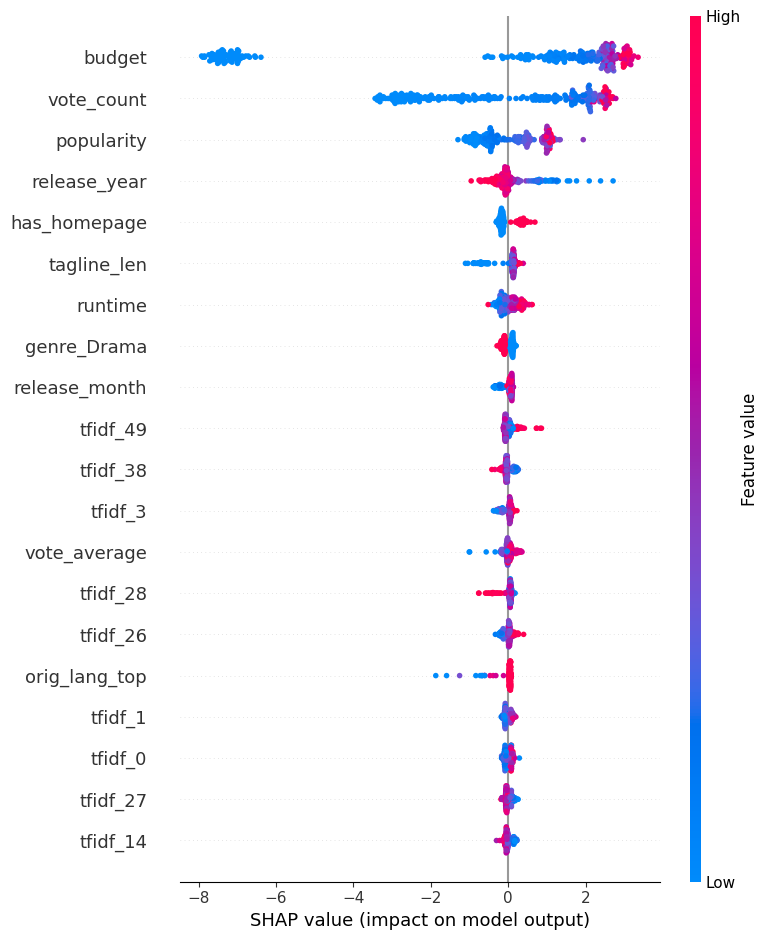

In [17]:

num_cols = base_numeric + genre_cols + tfidf_cols
feature_names = num_cols + cat_cols


Xtrain_shap = pd.DataFrame(X_train_prep, columns=feature_names)
sample = Xtrain_shap.sample(min(300, len(Xtrain_shap)), random_state=RND)

explainer = shap.TreeExplainer(best_xgr)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample, show=True)


## Resultados resumidos y conclusiones

A continuación se resumen las métricas principales para los modelos entrenados (regresión y clasificación).
Se discuten limitaciones y posibles mejoras para futuras versiones.


== REGRESIÓN ==
RF (reg): {'rmse': np.float64(4.717524490094535), 'mae': 3.1702281839540927, 'r2': 0.6996621846298312}
XGBoost (reg): {'rmse': np.float64(5.056737615949869), 'mae': 3.3952100351546313, 'r2': 0.6549178225803998}
Best XG (reg): {'rmse': np.float64(4.589654304577985), 'mae': 2.891092333184843, 'r2': 0.7157230537427124}

== CLASIFICACIÓN ==
RF (clf) f1_macro: 0.8685162663423533
XGBoost (clf) f1_macro: 0.8740758548917558
Best XG (clf) f1_macro: 0.8781483781402502


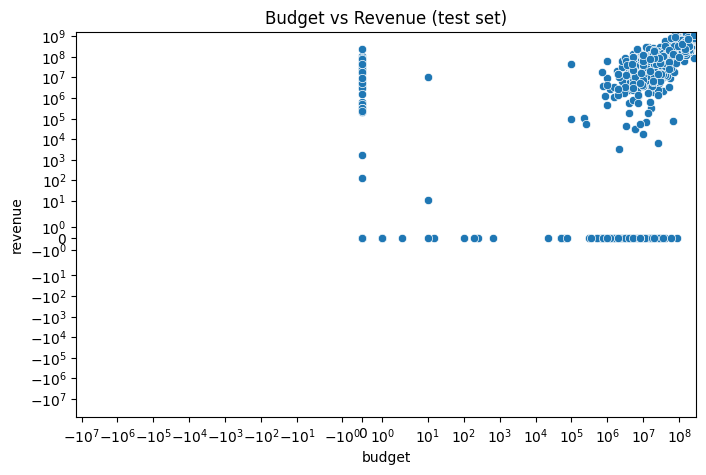

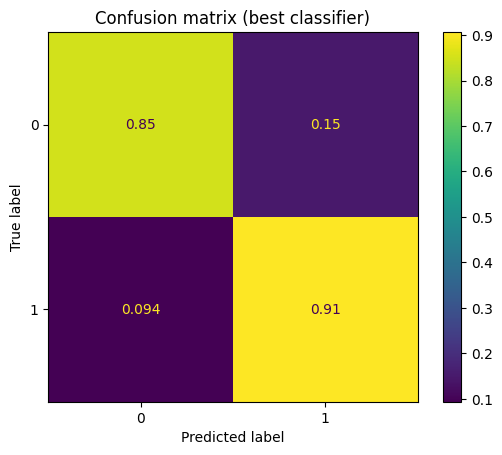

In [18]:

print("== REGRESIÓN ==")
print("RF (reg):", reg_metrics(yte_reg, pred_rf))
print("XGBoost (reg):", reg_metrics(yte_reg, pred_xg))
print("Best XG (reg):", reg_metrics(yte_reg, pred_best_reg))

print("\n== CLASIFICACIÓN ==")
print("RF (clf) f1_macro:", f1_score(yte_clf, pred_clf, average='macro'))
print("XGBoost (clf) f1_macro:", f1_score(yte_clf, pred_xgc, average='macro'))
print("Best XG (clf) f1_macro:", f1_score(yte_clf, pred_best_clf, average='macro'))


plt.figure(figsize=(8,5))
sns.scatterplot(data=df_sorted.iloc[cut:], x='budget', y='revenue')
plt.title('Budget vs Revenue (test set)')
plt.xscale('symlog'); plt.yscale('symlog'); plt.show()


from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(yte_clf, pred_best_clf, normalize='true')
plt.title('Confusion matrix (best classifier)')
plt.show()


In [19]:

joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(best_xgr, 'best_xg_regressor.joblib')
joblib.dump(best_xgc, 'best_xg_classifier.joblib')
joblib.dump(rf, 'rf_regressor_baseline.joblib')
joblib.dump(clf_rf, 'rf_classifier_baseline.joblib')
print("Modelos y preprocessor guardados en el workspace.")


Modelos y preprocessor guardados en el workspace.


## Limitaciones y trabajos futuros

- **Limitaciones:** el dataset no contiene información detallada de presupuesto de marketing ni de fechas exactas de estreno por zona; la variable `status`/`original_language` y la cardinalidad de equipos/personas puede influir. TF-IDF sobre `overview` ayuda, pero features de cast/crew (ranking de director/actores) y datos externos (premios, competencia en fecha de estreno, reviews) mejorarían el modelo.
- **Mejoras:** crear features de “reputación” por director/actor (ELO-like), usar embeddings del texto `overview`, hacer stacking con modelos ligeros, calibrar probabilidades para la clasificación y evaluar con TimeSeriesSplit para mayor robustez.
